In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report,confusion_matrix

import time

In [2]:
x = torch.rand(5, 3)
print(x)
print(x.size())
y = torch.rand(5, 3)
z = x + y
print(z)
t = x.numpy()
print(t)
u = torch.from_numpy(t)
print(u)

tensor([[0.6127, 0.6820, 0.2027],
        [0.2521, 0.7725, 0.4371],
        [0.4966, 0.8517, 0.6814],
        [0.1092, 0.9823, 0.7345],
        [0.3466, 0.1094, 0.7131]])
torch.Size([5, 3])
tensor([[1.1524, 1.3249, 0.6441],
        [0.4991, 1.6321, 1.4121],
        [1.0437, 1.1209, 1.6487],
        [1.0202, 1.1897, 0.9030],
        [0.5524, 0.8504, 1.0614]])
[[0.61271435 0.68197167 0.20272791]
 [0.2520677  0.77252984 0.43707693]
 [0.49660766 0.85171604 0.68142396]
 [0.10917765 0.98233765 0.73446816]
 [0.34664464 0.10944206 0.71311504]]
tensor([[0.6127, 0.6820, 0.2027],
        [0.2521, 0.7725, 0.4371],
        [0.4966, 0.8517, 0.6814],
        [0.1092, 0.9823, 0.7345],
        [0.3466, 0.1094, 0.7131]])


In [3]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10
# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
torch.nn.Linear(D_in, H),
torch.nn.ReLU(),
torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()
    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

99 42.014129638671875
199 0.574786901473999
299 0.0030316589400172234
399 9.283474355470389e-06
499 1.4790353830562708e-08


In [4]:
import torch
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out): #D_in: input layer, H: hidden layer, D_out: output layer
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

In [5]:
N, D_in, H, D_out = 64, 1000, 100, 10
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)
model = TwoLayerNet(D_in, H, D_out)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 1.49753737449646
199 0.019455822184681892
299 0.0005275917937979102
399 1.9685712686623447e-05
499 8.689493711244722e-07


#### 2. Building cnn with torch

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True, #for training
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4, #process only 4 images at a time
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False, #not for training
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4, #process only 4 images at a time
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


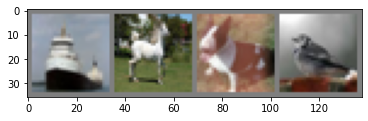

 ship horse   dog  bird


In [7]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print true labels of the images
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #x = self.conv1(x), x = F.relu(x), x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x))) #x = self.conv2(x), x = F.relu(x), x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5) #flatten a 16x5x5 tensor to 16x5x5-dimensional vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_history = []
epoch = 2

[1,  2000] loss: 2.201
[1,  4000] loss: 1.843
[1,  6000] loss: 1.673
[1,  8000] loss: 1.575
[1, 10000] loss: 1.502
[1, 12000] loss: 1.453
[2,  2000] loss: 1.385
[2,  4000] loss: 1.346
[2,  6000] loss: 1.313
[2,  8000] loss: 1.313
[2, 10000] loss: 1.276
[2, 12000] loss: 1.284
Finished CIFAR Training in time: 138.22674226760864


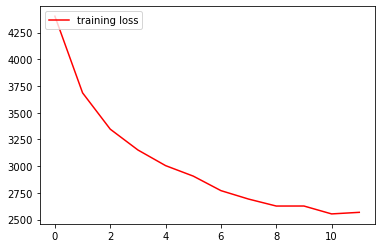

In [10]:
start = time.time() 

for e in range(epoch): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0
            
time1 = time.time() - start
print('Finished CIFAR Training in time:', time1)
plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()

In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

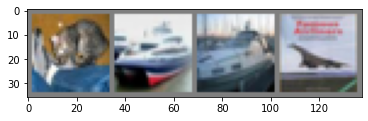

GroundTruth:    cat  ship  ship plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
#load the trained network
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

In [14]:
_, predicted_labels = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted_labels[j]]
for j in range(4)))

Predicted:    cat   car   car plane


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data
        outputs = net(images)
        _, predicted_labels = torch.max(outputs.data, 1)
        total += groundtruth_labels.size(0)
        correct += (predicted_labels == groundtruth_labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

predicted_labels_entire = []
groundtruth_labels_entire = []

start = time.time()
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data
        
        groundtruth_labels_entire += groundtruth_labels
        
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
           
        predicted_labels_entire += predicted_labels

        c = (predicted_labels == groundtruth_labels).squeeze()
        for i in range(4):
            label = groundtruth_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
time1 = time.time() - start
print('Finished CIFAR Testing in time: ', time1)
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
cm = confusion_matrix(groundtruth_labels_entire, predicted_labels_entire)
print ("Confusion matrix: \n", cm)

Finished CIFAR Testing in time:  5.601983308792114
Accuracy of plane : 62 %
Accuracy of   car : 70 %
Accuracy of  bird : 55 %
Accuracy of   cat : 32 %
Accuracy of  deer : 35 %
Accuracy of   dog : 56 %
Accuracy of  frog : 60 %
Accuracy of horse : 68 %
Accuracy of  ship : 53 %
Accuracy of truck : 60 %
Confusion matrix: 
 [[628  39  92  22  22  17  22  44  69  45]
 [ 34 703  11  17   9  14  21  26  24 141]
 [ 69   6 558  68  75  99  48  56  12   9]
 [ 28  19 119 329  49 259  86  87   9  15]
 [ 41   4 230  61 352 104  69 125   8   6]
 [ 10   2 122 133  40 560  28  89   5  11]
 [  3   5 104  69  99  83 600  26   2   9]
 [  8   4  79  45  36 120   7 687   3  11]
 [168  95  38  19  18  17  14  21 538  72]
 [ 36 182  11  22  11  20  29  66  16 607]]


In [17]:
print (predicted_labels)
print (groundtruth_labels)

tensor([3, 5, 1, 7])
tensor([3, 5, 1, 7])


#### Custom Data

In [18]:
transform = transforms.Compose(
    [transforms.Resize((32,32)), # you can change the image size, but need to change the architecture accordingly
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.ImageFolder('FoodImages/Train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4, #process only 4 images at a time
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder('FoodImages/Test', transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4, #process only 4 images at a time
                                         shuffle=False, num_workers=2)
classes = ('Cakes', 'Pasta', 'Pizza')

In [19]:
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print (labels)

tensor([1, 0, 2, 2])
tensor([1, 0, 0, 0])
tensor([2, 2, 2, 2])
tensor([1, 0, 0, 0])
tensor([1, 0, 1, 2])
tensor([0, 1, 0, 0])
tensor([0, 0, 1, 1])
tensor([2, 0, 1, 1])
tensor([2, 2, 0, 2])
tensor([2, 0, 0, 2])
tensor([1, 1, 2, 1])
tensor([2, 0, 1, 0])
tensor([2, 0, 1, 1])
tensor([1, 2, 2, 2])
tensor([1, 1, 0, 1])
tensor([2, 2, 1, 1])
tensor([1, 0, 0, 2])
tensor([2, 0, 1, 0])
tensor([0, 0, 2, 1])
tensor([0, 1, 1, 2])
tensor([0, 2, 1, 2])
tensor([2, 1, 2, 1])
tensor([0, 2])


In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #x = self.conv1(x), x = F.relu(x), x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x))) #x = self.conv2(x), x = F.relu(x), x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5) #flatten a 16x5x5 tensor to 16x5x5-dimensional vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

[1,    10] loss: 0.006
[1,    20] loss: 0.006
[2,    10] loss: 0.006
[2,    20] loss: 0.005
[3,    10] loss: 0.006
[3,    20] loss: 0.005
[4,    10] loss: 0.005
[4,    20] loss: 0.005
[5,    10] loss: 0.005
[5,    20] loss: 0.005
[6,    10] loss: 0.005
[6,    20] loss: 0.005
[7,    10] loss: 0.005
[7,    20] loss: 0.005
[8,    10] loss: 0.005
[8,    20] loss: 0.005
[9,    10] loss: 0.005
[9,    20] loss: 0.005
[10,    10] loss: 0.005
[10,    20] loss: 0.005
Finished Training in time: (avg time per epoch) 3.0009121656417848


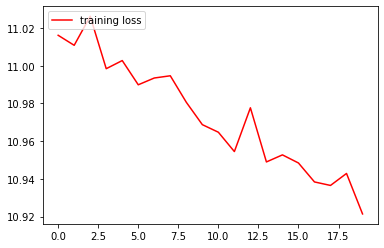

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_history = []
epoch = 10

start = time.time()
for e in range(epoch): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0
            
time1 = time.time() - start
print('Finished Training in time: (avg time per epoch)', time1/epoch)
plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()

In [31]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

predicted_labels_entire = []
groundtruth_labels_entire = []

start = time.time()
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data
        
        groundtruth_labels_entire += groundtruth_labels
        
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
           
        predicted_labels_entire += predicted_labels

        c = (predicted_labels == groundtruth_labels).squeeze()
        for i in range(2):
            label = groundtruth_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
time1 = time.time() - start
print('Finished CPU scratch Testing in time: ', time1)        
for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
cm = confusion_matrix(groundtruth_labels_entire, predicted_labels_entire)
print ("Confusion matrix: \n", cm)

Finished CPU scratch Testing in time:  2.0737481117248535
Accuracy of Cakes : 37 %
Accuracy of Pasta : 21 %
Accuracy of Pizza : 68 %
Confusion matrix: 
 [[11  9 10]
 [17  5  8]
 [ 7  1 22]]


In [23]:
PATH = './cifar_net.pth'
net = Net()
net.fc3 = nn.Linear(84, 10) #To load the pretrained weights
net.load_state_dict(torch.load(PATH))
net.fc3 = nn.Linear(84, 3)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


[1,    10] loss: 0.006
[1,    20] loss: 0.005
[2,    10] loss: 0.005
[2,    20] loss: 0.005
[3,    10] loss: 0.004
[3,    20] loss: 0.004
[4,    10] loss: 0.003
[4,    20] loss: 0.003
[5,    10] loss: 0.002
[5,    20] loss: 0.003
[6,    10] loss: 0.002
[6,    20] loss: 0.002
[7,    10] loss: 0.002
[7,    20] loss: 0.002
[8,    10] loss: 0.001
[8,    20] loss: 0.001
[9,    10] loss: 0.001
[9,    20] loss: 0.001
[10,    10] loss: 0.001
[10,    20] loss: 0.000
Finished fine tuned Training in time (avg time per epoch):  1.0502771615982056


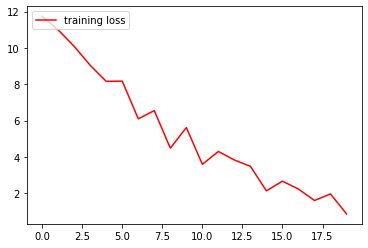

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_history = []
epoch = 10

start = time.time()
for e in range(epoch): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0
            
time1 = time.time() - start
print('Finished fine tuned Training in time (avg time per epoch): ', time1/epoch)
plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()

In [25]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

predicted_labels_entire = []
groundtruth_labels_entire = []

start = time.time()
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data
        
        groundtruth_labels_entire += groundtruth_labels
        
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
           
        predicted_labels_entire += predicted_labels

        c = (predicted_labels == groundtruth_labels).squeeze()
        for i in range(2):
            label = groundtruth_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

time1 = time.time() - start
print('Finished CPU finetuned Testing in time: ', time1)

for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
cm = confusion_matrix(groundtruth_labels_entire, predicted_labels_entire)
print ("Confusion matrix: \n", cm)


Finished CPU finetuned Testing in time:  1.0492591857910156
Accuracy of Cakes : 75 %
Accuracy of Pasta : 100 %
Accuracy of Pizza : 81 %
Confusion matrix: 
 [[21  5  4]
 [ 0 27  3]
 [ 0  6 24]]


#### GPU Training and testing

In [26]:
PATH = './cifar_net.pth'
net = Net()
net.fc3 = nn.Linear(84, 10) #To load the pretrained weights
net.load_state_dict(torch.load(PATH))
net.fc3 = nn.Linear(84, 3)
print(net)
net = Net()


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


cuda:0
[1,    20] loss: 0.011
[2,    20] loss: 0.011
[3,    20] loss: 0.011
[4,    20] loss: 0.011
[5,    20] loss: 0.011
[6,    20] loss: 0.011
[7,    20] loss: 0.011
[8,    20] loss: 0.011
[9,    20] loss: 0.010
[10,    20] loss: 0.010
[11,    20] loss: 0.010
[12,    20] loss: 0.010
[13,    20] loss: 0.009
[14,    20] loss: 0.009
[15,    20] loss: 0.009
[16,    20] loss: 0.008
[17,    20] loss: 0.008
[18,    20] loss: 0.007
[19,    20] loss: 0.007
[20,    20] loss: 0.007
Finished GPU Training in time:(avg time per epoch)  1.107454788684845


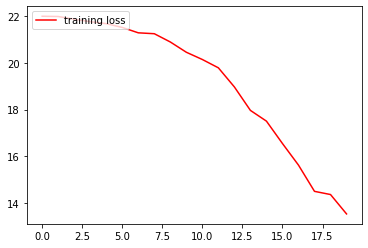

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)
net = net.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_history = []
epoch = 20

start = time.time()
for e in range(epoch): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0
            
time1 = time.time() - start
print('Finished GPU Training in time:(avg time per epoch) ', time1/epoch)
plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()

In [28]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

predicted_labels_entire = []
groundtruth_labels_entire = []

start = time.time()
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        
        groundtruth_labels_entire += groundtruth_labels.cpu()
        
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
           
        predicted_labels_entire += predicted_labels.cpu()

        c = (predicted_labels == groundtruth_labels).squeeze()
        for i in range(2):
            label = groundtruth_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

time1 = time.time() - start
print('Finished GPU Testing in time: ', time1)

for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
cm = confusion_matrix(groundtruth_labels_entire, predicted_labels_entire)
print ("Confusion matrix: \n", cm)



Finished GPU Testing in time:  0.9928574562072754
Accuracy of Cakes : 81 %
Accuracy of Pasta : 85 %
Accuracy of Pizza : 75 %
Confusion matrix: 
 [[22  5  3]
 [ 2 21  7]
 [ 1  9 20]]
